# Forecasting Monthly Inflation Rate in Purwokerto City using ARIMA

This project is the final report of the internship at Badan Pusat Statistik Kabupaten Banyumas from January 2020 to February 2020. The data used for analysis is the monthly inflation of the city of Purwokerto from January 2012 to August 2020.

In [43]:
import numpy as np
from numpy import sqrt
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

In [38]:
#import dataset
dataset = pd.read_excel(r'C:\Inflation Rate Purwokerto 2012-2020.xlsx', header=0)
dataset['Date'] = pd.to_datetime(dataset['Date'],infer_datetime_format=True)
Idxdataset=dataset.set_index(['Date'])

In [39]:
from datetime import datetime
Idxdataset.head(5)

,Inflation
Date,
2012-01-01,0.68
2012-02-01,0.56
2012-03-01,-0.21
2012-04-01,0.09
2012-05-01,0.43


After the dataset has been imported into the notebook, we plot the time series data to see the stationarity of the data in terms of mean and variance. It means that the mean and variance are not functions of time.

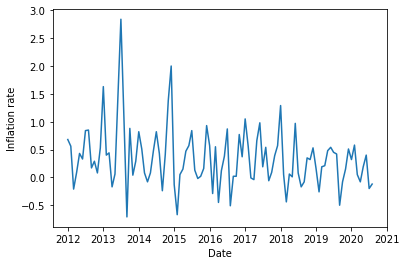

In [40]:
#plot the time series
plt.xlabel('Date')
plt.ylabel('Inflation rate')
plt.plot(Idxdataset)

From the plot above shown that the data stationary in a mean but not in a variance. We can calculate moving mean and moving standard deviation and then plotting it with the original data so the vizualisation more interpretable.

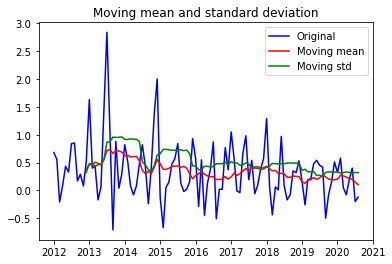

In [76]:
#calculating moving statistics
rolmean = Idxdataset.rolling(window=12).mean()
rolstd = Idxdataset.rolling(window=12).std()

#plotting moving statistics
orig=plt.plot(Idxdataset,color='Blue',label='Original')
mean=plt.plot(rolmean,color='Red',label='Moving mean')
std=plt.plot(rolstd,color='Green',label='Moving std')
plt.legend(loc='best')
plt.title('Moving mean and standard deviation')
plt.show(block=False)

The square root is used to reduce the variance. For further ensure the stationarity of the data, Dickey-Fuller Test can be used as a confirmatory analysis. The null hypothesis is that the data is not stationary in the mean.

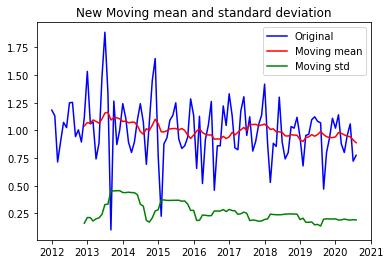

In [77]:
#transform data--add by 0.72 so it can be transformed with sqrt
datatrans=sqrt(Idxdataset.transform(lambda x: x+0.72))

#calculating new moving statistics
rolmeannew = datatrans.rolling(window=12).mean()
rolstdnew = datatrans.rolling(window=12).std()

#plotting new moving statistics
orig=plt.plot(datatrans,color='Blue',label='Original')
mean=plt.plot(rolmeannew,color='Red',label='Moving mean')
std=plt.plot(rolstdnew,color='Green',label='Moving std')
plt.legend(loc='best')
plt.title('New Moving mean and standard deviation')
plt.show(block=False)

In [78]:
#Perform Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

print('Results of Dickey-Fuller Test:')
dftest = adfuller(datatrans['Inflation'],autolag='AIC')

dfoutput = pd.Series(dftest[0:4],index=['Test statistic','p-value','#Lags used','Number of observations used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key]=value

print(dfoutput)

Results of Dickey-Fuller Test:
Test statistic                -8.739473e+00
p-value                        3.036368e-14
#Lags used                     2.000000e+00
Number of observations used    1.010000e+02
Critical Value (1%)           -3.496818e+00
Critical Value (5%)           -2.890611e+00
Critical Value (10%)          -2.582277e+00
dtype: float64


At 5% level significance we can conclude that the time series is stationary in mean because the absolute test statistic is greater than absolute 5% critical value. therefore, after we have proven that the data is stationary in mean and variance then the assumptions for creating ARIMA models are fullfilled.

## Identification Model

There are 104 observations in the data set. The Arima model has three parameters they are p,d, and q. p parameter refers to the order of AR, d parameter refers to the level of differencing and q parameter refers to the order of MA. Since the differencing of data is not needed to fulfill the assumption (stationary data) so the d parameter is 0. 
The first 80 observations are used for training data and the rest of them are used for testing.

In [79]:
# Create Training and Test
train = datatrans[:80]
test = datatrans[80:]

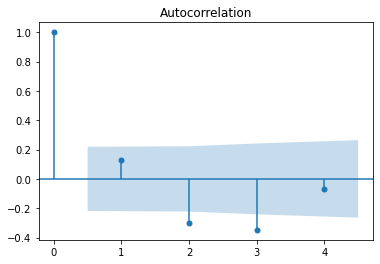

In [80]:
#plotting ACF
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(train,lags=4)
plt.show()

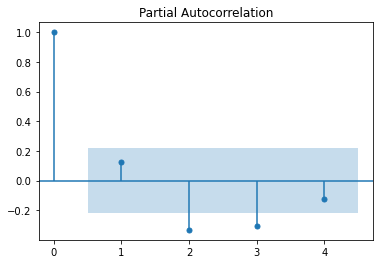

In [81]:
#plotting PACF
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(train,lags=4)
plt.show()

It can be seen in the two plots above that the PACF value cut-off occurs after the second lag so it is determined that there is an AR(3) process. In the ACF plot above occurs cut-off after the third lag so that it is determined that there is an MA(3) process. In this analysis, the determination of the inital model limit is only up to lags 4 so that the estimated parameters aren't too many. So the inital ARIMA model is ARIMA (3,0,3).

auto arima() function helps us when underfitting the initial model to find the best model. it works with to search multiple combinations of p and q  parameters and choose the best model that has least AIC.

In [82]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
model = pm.auto_arima(train, start_p=1, start_q=1,
                      max_p=3, max_q=3, # maximum p and q based on initial model
                      m=1,              # frequency of series
                      d=0,              # no differencing needed
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                       scoring='mse')

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=237.451, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=72.913, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=170.921, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=70.748, Time=0.07 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=66.405, Time=0.12 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=32.731, Time=0.30 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.43 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.39 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=18.604, Time=0.31 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=18.834, Time=0.46 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=17.223, Time=0.15 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=22.470, Time=0.09 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0] intercept
Total fit time: 2.972 se

The best model that has been calculated is ARIMA(3,0,0) with intercept. Then we must review the residual plots for diagnostic checking.

## Diagnostic 

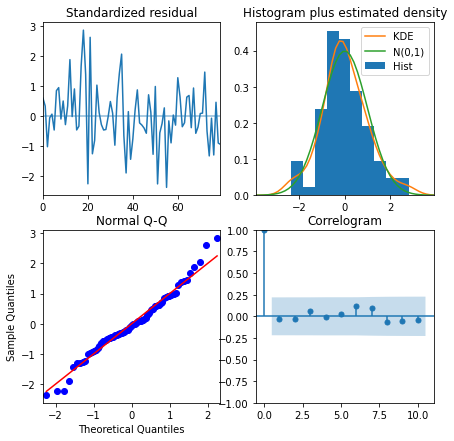

In [83]:
model.plot_diagnostics(figsize=(7,7))
plt.show()

The residual errors seem to fluctuate around a mean of zero and have a uniform variance (residuals 
homoscedasticity). (Top Left)

The density plot suggest normal distribution with mean zero (residuals normality). (Top right) and (Bottom left)

The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated (residuals aren't autocorrelated). (Bottom right)

Overall, ARIMA (3,0,0) with intercept is to be a good fit with our data and can be used for forecasting.

In [84]:
#forecasting
prediction = pd.DataFrame(model.predict(n_periods=len(test)),index=test.index)
prediction.columns = ['Predicted_Inflation']
print(prediction)

            Predicted_Inflation
Date                           
2018-09-01             0.945596
2018-10-01             1.121213
2018-11-01             1.123649
2018-12-01             1.016180
2019-01-01             0.956024
2019-02-01             0.980071
2019-03-01             1.029757
2019-04-01             1.044553
2019-05-01             1.025081
2019-06-01             1.005031
2019-07-01             1.004498
2019-08-01             1.015626
2019-09-01             1.022481
2019-10-01             1.020118
2019-11-01             1.014813
2019-12-01             1.013051
2020-01-01             1.015056
2020-02-01             1.017241
2020-03-01             1.017375
2020-04-01             1.016202
2020-05-01             1.015438
2020-06-01             1.015661
2020-07-01             1.016229
2020-08-01             1.016435


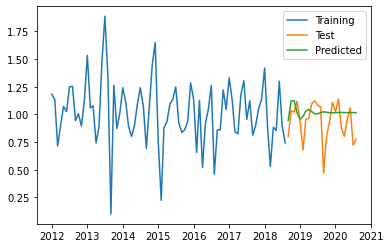

In [85]:
plt.plot(train,label='Training')
plt.plot(test,label='Test')
plt.plot(prediction,label='Predicted')

plt.legend(loc ='best')
plt.show()

In [86]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'mape':mape, 'rmse':rmse})

forecast_accuracy(test.Inflation, prediction.Predicted_Inflation)

{'mape': 0.13558940733290473, 'rmse': 0.18076691815859003}

The large MAPE and MSE indicate that the model obtained is not good for long-term forecasting. Maybe it's better if it is used to forecast one or two periods.
